In [126]:
# Advanced Analysis: Inspect learned step sizes across all layers

def analyze_learned_parameters(model, J_value):
    """
    Analyze and visualize learned step sizes across all layers
    """
    num_layers = len(model.layers)
    
    # Extract step sizes from each layer
    mu_values = []  # List of arrays, one per layer
    lambda_values = []  # List of scalars, one per layer
    
    for i, layer in enumerate(model.layers):
        mu_values.append(layer.mu.detach().cpu().numpy())
        lambda_values.append(layer.lambda_.detach().cpu().item())
    
    # Convert to arrays for easier plotting
    mu_array = np.array(mu_values)  # Shape: (I_max, J)
    lambda_array = np.array(lambda_values)  # Shape: (I_max,)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Heatmap of mu values across layers and inner iterations
    im1 = axes[0, 0].imshow(mu_array.T, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[0, 0].set_xlabel('Layer (Outer Iteration i)', fontsize=11)
    axes[0, 0].set_ylabel('Inner Iteration j', fontsize=11)
    axes[0, 0].set_title(f'Learned μ Values (J={J_value})', fontsize=12)
    plt.colorbar(im1, ax=axes[0, 0], label='μ value')
    
    # 2. Lambda values across layers
    axes[0, 1].plot(lambda_array, linewidth=2, color='green', marker='.')
    axes[0, 1].set_xlabel('Layer (Outer Iteration i)', fontsize=11)
    axes[0, 1].set_ylabel('λ value', fontsize=11)
    axes[0, 1].set_title(f'Learned λ Values Across Layers', fontsize=12)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Mean mu per layer
    mu_mean_per_layer = mu_array.mean(axis=1)
    axes[1, 0].plot(mu_mean_per_layer, linewidth=2, color='orange', marker='.')
    axes[1, 0].set_xlabel('Layer (Outer Iteration i)', fontsize=11)
    axes[1, 0].set_ylabel('Mean μ value', fontsize=11)
    axes[1, 0].set_title('Average μ Across Inner Iterations', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distribution of mu values
    axes[1, 1].hist(mu_array.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('μ value', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Distribution of Learned μ Values', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*60}")
    print(f"Learned Parameter Statistics (J={J_value})")
    print(f"{'='*60}")
    print(f"μ (step size for A):")
    print(f"  Mean: {mu_array.mean():.6f}")
    print(f"  Std:  {mu_array.std():.6f}")
    print(f"  Min:  {mu_array.min():.6f}")
    print(f"  Max:  {mu_array.max():.6f}")
    print(f"\nλ (step size for D):")
    print(f"  Mean: {lambda_array.mean():.6f}")
    print(f"  Std:  {lambda_array.std():.6f}")
    print(f"  Min:  {lambda_array.min():.6f}")
    print(f"  Max:  {lambda_array.max():.6f}")
    print(f"{'='*60}\n")
    
    return mu_array, lambda_array

def compare_layer_convergence(model, test_channel_idx=0):
    """
    Visualize how precoders evolve through layers for a single channel
    """
    model.eval()
    
    # Generate test channel
    H_test = generate_channel_torch(N, M, L=20, device=device)
    snr_db = 10  # Fixed SNR for visualization
    
    # Get Psi
    Psi_np = compute_psi(snr_db)
    Psi = torch.tensor(Psi_np, dtype=torch.cfloat, device=device)
    
    # Compute power
    P_BS = sigma_n2 * 10**(snr_db / 10)
    P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
    
    # Initialize
    A, D = proposed_initialization_torch(H_test, theta_d_t, N, M, K, P_BS, device=device)
    
    # Track metrics through layers
    rates = []
    taus = []
    objectives = []
    
    with torch.no_grad():
        for i, layer in enumerate(model.layers):
            A, D = layer(H_test, A, D, Psi, sigma_n2_t, P_BS_t)
            
            # Compute metrics
            R = compute_rate_torch(H_test, A, D, sigma_n2_t)
            tau = compute_tau_torch(A, D, Psi)
            obj = R - omega * tau
            
            rates.append(R.item())
            taus.append(tau.item())
            objectives.append(obj.item())
    
    # Plot evolution
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(rates, linewidth=2, color='blue')
    axes[0].set_xlabel('Layer', fontsize=11)
    axes[0].set_ylabel('Rate R (bps/Hz)', fontsize=11)
    axes[0].set_title('Communication Rate Evolution', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(taus, linewidth=2, color='red')
    axes[1].set_xlabel('Layer', fontsize=11)
    axes[1].set_ylabel('Beampattern Error τ', fontsize=11)
    axes[1].set_title('Sensing Error Evolution', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(objectives, linewidth=2, color='purple')
    axes[2].set_xlabel('Layer', fontsize=11)
    axes[2].set_ylabel('Objective R - ωτ', fontsize=11)
    axes[2].set_title('Objective Function Evolution', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final metrics at SNR={snr_db} dB:")
    print(f"  Rate R: {rates[-1]:.4f} bps/Hz")
    print(f"  Sensing error τ: {taus[-1]:.4f}")
    print(f"  Objective: {objectives[-1]:.4f}")

print("Advanced analysis functions ready!")
print("\nExample usage:")
print("  # Analyze learned parameters:")
print("  mu_array, lambda_array = analyze_learned_parameters(model, J_value=10)")
print("\n  # Visualize convergence through layers:")
print("  compare_layer_convergence(model)")

Advanced analysis functions ready!

Example usage:
  # Analyze learned parameters:
  mu_array, lambda_array = analyze_learned_parameters(model, J_value=10)

  # Visualize convergence through layers:
  compare_layer_convergence(model)


In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [128]:
# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 120  # Maximum outer iterations
sigma_n2 = 1.0  # Noise variance
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel

# Convert to tensors
omega_t = torch.tensor(omega, dtype=torch.float32, device=device)
sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
mu_t = torch.tensor(mu, dtype=torch.float32, device=device)
lambda_t = torch.tensor(lambda_, dtype=torch.float32, device=device)

In [129]:
# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Convert to tensors
theta_d_t = torch.tensor(theta_d, dtype=torch.float32, device=device)
theta_grid_t = torch.tensor(theta_grid, dtype=torch.float32, device=device)
B_d_t = torch.tensor(B_d, dtype=torch.float32, device=device)

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

k_t = torch.tensor(k, dtype=torch.float32, device=device)
d_t = torch.tensor(d, dtype=torch.float32, device=device)

In [130]:
# Step 3: Channel Matrix Generation (Saleh-Valenzuela Model) - PyTorch Version
def generate_channel_torch(N, M, L, device=device):
    """Generate channel using PyTorch tensors"""
    H = torch.zeros((M, N), dtype=torch.cfloat, device=device)
    
    for _ in range(L):
        # Complex gain
        alpha_real = torch.randn(1, device=device) / np.sqrt(2)
        alpha_imag = torch.randn(1, device=device) / np.sqrt(2)
        alpha = torch.complex(alpha_real, alpha_imag).squeeze()
        
        # Angles
        phi_r = torch.rand(1, device=device).item() * 2 * np.pi
        phi_t = torch.rand(1, device=device).item() * 2 * np.pi
        
        # Steering vectors
        a_r_phase = 1j * k_t * d_t * torch.arange(M, dtype=torch.float32, device=device) * np.sin(phi_r)
        a_r = torch.exp(a_r_phase) / np.sqrt(M)
        
        a_t_phase = 1j * k_t * d_t * torch.arange(N, dtype=torch.float32, device=device) * np.sin(phi_t)
        a_t = torch.exp(a_t_phase) / np.sqrt(N)
        
        H += np.sqrt(N * M / L) * alpha * torch.outer(a_r, a_t.conj())
    
    return H

# NumPy version for compatibility
def generate_channel(N, M, L):
    """Original NumPy version"""
    H = np.zeros((M, N), dtype=complex)
    for _ in range(L):
        alpha = np.random.normal(0, 1, 2).view(complex)[0] / np.sqrt(2)
        phi_r = np.random.uniform(0, 2 * np.pi)
        phi_t = np.random.uniform(0, 2 * np.pi)
        a_r = np.exp(1j * k * d * np.arange(M) * np.sin(phi_r)) / np.sqrt(M)
        a_t = np.exp(1j * k * d * np.arange(N) * np.sin(phi_t)) / np.sqrt(N)
        H += np.sqrt(N * M / L) * alpha * np.outer(a_r, a_t.conj())
    return H

# Steering vector function - PyTorch version
def steering_vector_torch(theta, N, device=device):
    """Compute steering vector using PyTorch"""
    phase = 1j * k_t * d_t * torch.arange(N, dtype=torch.float32, device=device) * torch.sin(torch.tensor(theta, device=device))
    return torch.exp(phase) / torch.sqrt(torch.tensor(N, dtype=torch.float32, device=device))

# NumPy version
def steering_vector(theta, N):
    """Original NumPy version"""
    return np.exp(1j * k * d * np.arange(N) * np.sin(theta)) / np.sqrt(N)

# Compute communication rate R - PyTorch version (FIXED)
def compute_rate_torch(H, A, D, sigma_n2):
    """Compute rate using PyTorch tensors - Fixed version"""
    xi = 1 / torch.log(torch.tensor(2.0, device=device))
    R = torch.tensor(0.0, device=device)
    K = H.shape[0]
    
    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)  # (N x 1)
        d_k = D[:, k].reshape(-1, 1)  # (M x 1)

        # Use .item() to extract scalar values and avoid shape issues
        num = torch.abs(h_k.conj().T @ A @ d_k)**2
        num = num.squeeze()  # Remove all dimensions of size 1
        
        denom = sigma_n2
        for j in range(K):
            if j != k:
                interference = torch.abs(h_k.conj().T @ A @ D[:, j].reshape(-1, 1))**2
                denom = denom + interference.squeeze()
        
        R = R + xi * torch.log2(1 + num / denom)
    
    return R

# NumPy version
def compute_rate(H, A, D, sigma_n2):
    """Original NumPy version"""
    xi = 1 / np.log(2)
    R = 0
    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        d_k = D[:, k].reshape(-1, 1)
        num = np.abs(h_k.conj().T @ A @ d_k)**2
        denom = sigma_n2 + np.sum([np.abs(h_k.conj().T @ A @ D[:, j].reshape(-1, 1))**2 
                                   for j in range(K) if j != k])
        R += xi * np.log2(1 + num / denom)
    return R

# Compute sensing error tau - PyTorch version
def compute_tau_torch(A, D, Psi):
    """Compute sensing error using PyTorch"""
    tau = torch.linalg.norm(A @ D @ D.conj().T @ A.conj().T - Psi, ord='fro')**2
    return tau

# NumPy version
def compute_tau(A, D, Psi, theta_grid):
    """Original NumPy version"""
    tau = np.linalg.norm(A @ D @ D.conj().T @ A.conj().T - Psi, 'fro')**2
    return tau

# Gradients - PyTorch versions with numerical stability
def gradient_R_A_torch(H, A, D, sigma_n2, eps=1e-10, clip_value=1e3):
    """Compute gradient of R w.r.t. A using PyTorch with numerical stability"""
    xi = 1 / torch.log(torch.tensor(2.0, device=device))
    grad_A = torch.zeros_like(A, dtype=torch.cfloat)
    K = H.shape[0]

    V = D @ D.conj().T

    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        H_tilde_k = h_k @ h_k.conj().T

        D_bar_k = D.clone()
        D_bar_k[:, k] = 0.0

        V_bar_k = D_bar_k @ D_bar_k.conj().T

        # Add epsilon for numerical stability
        denom1 = torch.trace(A @ V @ A.conj().T @ H_tilde_k) + sigma_n2 + eps
        denom2 = torch.trace(A @ V_bar_k @ A.conj().T @ H_tilde_k) + sigma_n2 + eps

        # Check for valid denominators
        if torch.abs(denom1) < eps or torch.abs(denom2) < eps:
            continue

        term1 = H_tilde_k @ A @ V / denom1
        term2 = H_tilde_k @ A @ V_bar_k / denom2

        grad_A += xi * (term1 - term2)

    # Clip gradients to prevent explosion
    grad_norm = torch.linalg.norm(grad_A, ord='fro')
    if grad_norm > clip_value:
        grad_A = grad_A * (clip_value / grad_norm)
    
    # Check for NaN/Inf
    if torch.isnan(grad_A).any() or torch.isinf(grad_A).any():
        return torch.zeros_like(A, dtype=torch.cfloat)

    return grad_A

def gradient_R_D_torch(H, A, D, sigma_n2, eps=1e-10, clip_value=1e3):
    """Compute gradient of R w.r.t. D using PyTorch with numerical stability"""
    xi = 1 / torch.log(torch.tensor(2.0, device=device))
    grad_D = torch.zeros_like(D, dtype=torch.cfloat)
    K = H.shape[0]

    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        H_tilde_k = h_k @ h_k.conj().T
        H_bar_k = A.conj().T @ H_tilde_k @ A

        D_bar_k = D.clone()
        D_bar_k[:, k] = 0.0

        # Add epsilon for numerical stability
        denom1 = torch.trace(D @ D.conj().T @ H_bar_k) + sigma_n2 + eps
        denom2 = torch.trace(D_bar_k @ D_bar_k.conj().T @ H_bar_k) + sigma_n2 + eps

        # Check for valid denominators
        if torch.abs(denom1) < eps or torch.abs(denom2) < eps:
            continue

        term1 = (H_bar_k @ D) / denom1
        term2 = (H_bar_k @ D_bar_k) / denom2

        grad_D += xi * (term1 - term2)

    # Clip gradients to prevent explosion
    grad_norm = torch.linalg.norm(grad_D, ord='fro')
    if grad_norm > clip_value:
        grad_D = grad_D * (clip_value / grad_norm)
    
    # Check for NaN/Inf
    if torch.isnan(grad_D).any() or torch.isinf(grad_D).any():
        return torch.zeros_like(D, dtype=torch.cfloat)

    return grad_D

def gradient_tau_A_torch(A, D, Psi, clip_value=1e3):
    """Compute gradient of tau w.r.t. A using PyTorch with numerical stability"""
    U = A @ D @ D.conj().T @ A.conj().T
    grad_A = 2 * (U - Psi) @ A @ D @ D.conj().T
    
    # Clip gradients to prevent explosion
    grad_norm = torch.linalg.norm(grad_A, ord='fro')
    if grad_norm > clip_value:
        grad_A = grad_A * (clip_value / grad_norm)
    
    # Check for NaN/Inf
    if torch.isnan(grad_A).any() or torch.isinf(grad_A).any():
        return torch.zeros_like(A, dtype=torch.cfloat)
    
    return grad_A

def gradient_tau_D_torch(A, D, Psi, clip_value=1e3):
    """Compute gradient of tau w.r.t. D using PyTorch with numerical stability"""
    U = A @ D @ D.conj().T @ A.conj().T
    grad_D = 2 * A.conj().T @ (U - Psi) @ A @ D
    
    # Clip gradients to prevent explosion
    grad_norm = torch.linalg.norm(grad_D, ord='fro')
    if grad_norm > clip_value:
        grad_D = grad_D * (clip_value / grad_norm)
    
    # Check for NaN/Inf
    if torch.isnan(grad_D).any() or torch.isinf(grad_D).any():
        return torch.zeros_like(D, dtype=torch.cfloat)
    
    return grad_D

# Original NumPy versions for backward compatibility
def gradient_R_A(H, A, D, sigma_n2):
    xi = 1 / np.log(2)
    grad_A = np.zeros_like(A, dtype=complex)
    V = D @ D.conj().T

    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        H_tilde_k = h_k @ h_k.conj().T
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0
        V_bar_k = D_bar_k @ D_bar_k.conj().T
        denom1 = np.trace(A @ V @ A.conj().T @ H_tilde_k) + sigma_n2
        denom2 = np.trace(A @ V_bar_k @ A.conj().T @ H_tilde_k) + sigma_n2
        term1 = H_tilde_k @ A @ V / denom1
        term2 = H_tilde_k @ A @ V_bar_k / denom2
        grad_A += xi * (term1 - term2)

    return grad_A

def gradient_R_D(H, A, D, sigma_n2):
    xi = 1 / np.log(2)
    grad_D = np.zeros_like(D, dtype=complex)

    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        H_tilde_k = h_k @ h_k.conj().T
        H_bar_k = A.conj().T @ H_tilde_k @ A
        D_bar_k = D.copy()
        D_bar_k[:, k] = 0.0
        denom1 = np.trace(D @ D.conj().T @ H_bar_k) + sigma_n2
        denom2 = np.trace(D_bar_k @ D_bar_k.conj().T @ H_bar_k) + sigma_n2
        term1 = (H_bar_k @ D) / denom1
        term2 = (H_bar_k @ D_bar_k) / denom2
        grad_D += xi * (term1 - term2)

    return grad_D

def gradient_tau_A(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T
    grad_A = 2 * (U - Psi) @ A @ D @ D.conj().T
    return grad_A

def gradient_tau_D(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T
    grad_D = 2 * A.conj().T @ (U - Psi) @ A @ D
    return grad_D

In [131]:
# Step 4: Initialization Strategies - PyTorch Versions

def proposed_initialization_torch(H, theta_d, N, M, K, P_BS, device=device):
    """Proposed initialization using PyTorch"""
    G = torch.stack([H[k, :] for k in range(K)]).T  # N x K
    A0 = torch.exp(-1j * torch.angle(G))[:, :M]
    X_ZF = torch.linalg.pinv(H)
    D0 = torch.linalg.pinv(A0) @ X_ZF
    D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
    return A0, D0

def random_initialization_torch(N, M, H, P_BS, device=device):
    """Random initialization using PyTorch"""
    A0 = torch.exp(1j * torch.rand((N, M), device=device) * 2 * np.pi)
    H_A = H @ A0
    D0 = torch.linalg.pinv(H_A)
    D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
    return A0, D0

def svd_initialization_torch(H, N, M, K, P_BS, device=device):
    """SVD initialization using PyTorch"""
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    A0 = Vh.T[:, :M]  # Take first M columns
    A0 = torch.exp(1j * torch.angle(A0))  # Project to unit modulus
    H_A = H @ A0
    try:
        D0 = torch.linalg.pinv(H_A)
    except:
        D0 = torch.linalg.pinv(H_A + 1e-6 * torch.eye(M, device=device, dtype=torch.cfloat))
    D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
    return A0, D0

# Original NumPy versions for backward compatibility
def proposed_initialization(H, theta_d, N, M, K, P_BS):
    G = np.array([H[k, :] for k in range(K)]).T  # N x K
    A0 = np.exp(-1j * np.angle(G))[:, :M]
    X_ZF = np.linalg.pinv(H)
    D0 = np.linalg.pinv(A0) @ X_ZF
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def random_initialization(N, M, H, P_BS):
    A0 = np.exp(1j * np.random.uniform(0, 2 * np.pi, (N, M)))
    H_A = H @ A0
    D0 = np.linalg.pinv(H_A)
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def svd_initialization(H, N, M, K, P_BS):
    _, _, Vh = svd(H, full_matrices=False)
    A0 = Vh.T[:, :M]
    A0 = np.exp(1j * np.angle(A0))
    H_A = H @ A0
    try:
        D0 = np.linalg.pinv(H_A)
    except np.linalg.LinAlgError:
        D0 = np.linalg.pinv(H_A + 1e-6 * np.eye(M))
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

In [132]:
# PGA Algorithm - PyTorch Version
def run_pga_torch(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, P_BS, device=device):
    """
    Run PGA algorithm using PyTorch tensors.
    All inputs should be PyTorch tensors on the specified device.
    """
    N, K = H.shape[1], H.shape[0]
    A = A0.clone()
    D = D0.clone()
    
    eta = 1.0 / N  # Balancing term

    for i in range(I_max):
        # ---- Inner Loop: Analog Precoder Update ----
        A_hat = A.clone()
        
        for j in range(J):
            grad_R_A = gradient_R_A_torch(H, A_hat, D, sigma_n2)
            grad_tau_A = gradient_tau_A_torch(A_hat, D, Psi)

            # Eq. (14b): Gradient Ascent on A
            grad_A = grad_R_A - omega * grad_tau_A
            A_hat = A_hat + mu * grad_A

            # Eq. (7): Unit Modulus Projection
            A_hat = torch.exp(1j * torch.angle(A_hat))

        A = A_hat.clone()

        # ---- Outer Loop: Digital Precoder Update ----
        grad_R_D = gradient_R_D_torch(H, A, D, sigma_n2)
        grad_tau_D = gradient_tau_D_torch(A, D, Psi)

        # Eq. (15): Gradient Ascent on D
        grad_D = grad_R_D - omega * eta * grad_tau_D
        D = D + lambda_ * grad_D

        # Eq. (9): Power Constraint Projection
        D = torch.sqrt(P_BS) * D / torch.linalg.norm(A @ D, ord='fro')

    # Compute final rate
    R = compute_rate_torch(H, A, D, sigma_n2)
    
    return R, A, D

# Original NumPy version
def run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid, P_BS):
    N, K = H.shape
    A = A0.copy()
    D = D0.copy()
    objectives = []
    eta = 1 / N

    for i in range(I_max):
        A_hat = A.copy()
        for j in range(J):
            grad_R_A = gradient_R_A(H, A_hat, D, sigma_n2)
            grad_tau_A = gradient_tau_A(A_hat, D, Psi)
            grad_A = grad_R_A - omega * grad_tau_A
            A_hat = A_hat + mu * grad_A
            A_hat = np.exp(1j * np.angle(A_hat))

        A = A_hat.copy()
        grad_R_D = gradient_R_D(H, A, D, sigma_n2)
        grad_tau_D = gradient_tau_D(A, D, Psi)
        grad_D = grad_R_D - omega * eta * grad_tau_D
        D = D + lambda_ * grad_D
        D = np.sqrt(P_BS) * D / np.linalg.norm(A @ D, 'fro')

    R = compute_rate(H, A, D, sigma_n2)
    return R, A, D

In [133]:
import h5py
SNR_dB_array = np.arange(0, 12.1, 0.1)
# Load Psi data (from MATLAB .mat file)
with h5py.File('Psi_all.mat', 'r') as f:
    Psi_h5 = f['Psi_all']

    # If stored as MATLAB complex structure (real/imag parts separate)
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)

# Ensure Psi_all has shape: (num_SNRs, M, N)
Psi_all = np.squeeze(Psi_all)  # remove singleton dimensions if any


def compute_psi(snr_db):
    """
    Selects the Psi matrix corresponding to the closest SNR value.
    """
    # Find index of closest SNR
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))

    # Select corresponding Psi
    Psi = Psi_all[idx, :, :]

    return Psi


In [134]:
# Zero-Forcing Baseline - PyTorch Version (FIXED)
def compute_R_ZF_torch(H, sigma_n2, P_BS, device=device):
    """
    Compute the achievable sum rate using Zero-Forcing precoding with PyTorch.
    H: (K x N) channel matrix (K users, N antennas)
    """
    K, N = H.shape

    # Ensure correct orientation (K x N)
    if H.shape[0] != K:
        H = H.T

    # ZF precoder
    X_ZF = H.conj().T @ torch.linalg.pinv(H @ H.conj().T)  # (N x K)

    # Normalize total transmit power
    X_ZF = torch.sqrt(P_BS) * X_ZF / torch.linalg.norm(X_ZF, ord='fro')

    # Compute sum rate
    R_ZF = torch.tensor(0.0, device=device)
    for k in range(K):
        h_k = H[k, :].reshape(1, -1)  # (1 x N)
        signal = torch.abs(h_k @ X_ZF[:, k])**2
        signal = signal.squeeze()  # Remove dimensions of size 1
        
        interference = torch.sum(torch.abs(h_k @ X_ZF)**2) - signal
        interference = interference.squeeze()  # Remove dimensions of size 1
        
        SINR = signal / (interference + sigma_n2)
        R_ZF = R_ZF + torch.log2(1 + SINR)
    
    return torch.real(R_ZF)

# Original NumPy version
def compute_R_ZF(H, sigma_n2, P_BS):
    """
    Compute the achievable sum rate using Zero-Forcing precoding.
    H: (K x N) channel matrix (K users, N antennas)
    """
    K, N = H.shape

    # Ensure correct orientation (K x N)
    if H.shape[0] != K:
        H = H.T

    # ZF precoder
    X_ZF = H.conj().T @ np.linalg.pinv(H @ H.conj().T)  # (N x K)

    # Normalize total transmit power
    X_ZF = np.sqrt(P_BS) * X_ZF / np.linalg.norm(X_ZF, 'fro')

    # Compute sum rate
    R_ZF = 0.0
    for k in range(K):
        h_k = H[k, :].reshape(1, -1)  # (1 x N)
        signal = np.abs(h_k @ X_ZF[:, k])**2
        interference = np.sum(np.abs(h_k @ X_ZF)**2) - signal
        SINR = signal / (interference + sigma_n2)
        R_ZF += np.log2(1 + SINR)
    return float(np.real(R_ZF))

In [135]:
# import numpy as np
# import matplotlib.pyplot as plt
# import torch

# snr_db_list = list(range(0, 13))
# num_realizations = 40
# J_values = [1]

# R_results = {}
# R_ZF_list = []

# # Choose whether to use PyTorch or NumPy (set to True for GPU acceleration)
# use_torch = torch.cuda.is_available()  # Use GPU if available
# print(f"Using {'PyTorch (GPU)' if use_torch else 'NumPy (CPU)'}")

# # --- Compute ZF baseline once ---
# print("=== Computing ZF baseline ===")
# for snr_db in snr_db_list:
#     R_ZF_sum = 0.0
#     P_BS = sigma_n2 * 10**(snr_db / 10)

#     for realization in range(num_realizations):
#         if use_torch:
#             H_t = generate_channel_torch(N, M, L, device=device)
#             if H_t.shape[0] != K:
#                 H_t = H_t.T
#             P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
#             R_ZF = compute_R_ZF_torch(H_t, sigma_n2_t, P_BS_t, device=device)
#             R_ZF_sum += R_ZF.item()
#         else:
#             H = generate_channel(N, M, L)
#             if H.shape[0] != K:
#                 H = H.T
#             R_ZF_sum += compute_R_ZF(H, sigma_n2, P_BS)

#     R_ZF_avg = R_ZF_sum / num_realizations
#     R_ZF_list.append(R_ZF_avg)
#     print(f"SNR = {snr_db} dB → ZF_Avg R = {R_ZF_avg:.4f}")

# # --- Compute PGA for each J ---
# for J in J_values:
#     R_PGA_list = []
#     print(f"\n=== Running PGA with J = {J} ===")

#     for snr_db in snr_db_list:
#         R_PGA_sum = 0.0
#         P_BS = sigma_n2 * 10**(snr_db / 10)

#         for realization in range(num_realizations):
#             Psi = compute_psi(snr_db)  # NumPy array
            
#             if use_torch:
#                 # Convert to PyTorch
#                 H_t = generate_channel_torch(N, M, L, device=device)
#                 Psi_t = torch.tensor(Psi, dtype=torch.cfloat, device=device)
#                 P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
                
#                 A0, D0 = proposed_initialization_torch(H_t, theta_d_t, N, M, K, P_BS, device=device)
#                 R_PGA, A_opt, D_opt = run_pga_torch(
#                     H_t, A0, D0, J=J, I_max=120, 
#                     mu=mu_t, lambda_=lambda_t, omega=omega_t,
#                     sigma_n2=sigma_n2_t, Psi=Psi_t, P_BS=P_BS_t, device=device
#                 )
#                 R_PGA_sum += R_PGA.item()
#             else:
#                 # Use NumPy
#                 H = generate_channel(N, M, L)
#                 A0, D0 = proposed_initialization(H, theta_d, N, M, K, P_BS)
#                 R_PGA, A_opt, D_opt = run_pga(
#                     H, A0, D0, J=J, I_max=120, mu=0.01,
#                     lambda_=0.01, omega=0.3,
#                     sigma_n2=sigma_n2, Psi=Psi,
#                     theta_grid=theta_grid, P_BS=P_BS
#                 )
#                 R_PGA_sum += float(R_PGA)

#         R_PGA_avg = R_PGA_sum / num_realizations
#         R_PGA_list.append(R_PGA_avg)
#         print(f"SNR = {snr_db} dB → PGA_Avg R = {R_PGA_avg:.4f}")

#     R_results[J] = R_PGA_list

# # --- Plot ---
# plt.figure(figsize=(8, 6))

# # Plot ZF baseline once
# plt.plot(snr_db_list, R_ZF_list, marker='x', linewidth=2,
#          color='black', label='ZF (digital baseline)')

# # Plot PGA results for each J
# for J in J_values:
#     plt.plot(snr_db_list, R_results[J], marker='o', linewidth=2,
#              label=f'PGA (J = {J})')

# plt.xlabel('SNR (dB)')
# plt.ylabel('Average Rate R (bps/Hz)')
# plt.title(f'Average Communication Rate vs SNR ({"PyTorch GPU" if use_torch else "NumPy CPU"})')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [137]:
import torch.nn as nn
import torch.optim as optim

# Projection functions for PyTorch
def project_unit_modulus(A):
    """Project A onto unit modulus constraint"""
    return torch.exp(1j * torch.angle(A))

def project_power_constraint(A, D, P_BS):
    """Project D to satisfy power constraint"""
    norm_factor = torch.sqrt(P_BS) / torch.linalg.norm(A @ D, ord='fro')
    return D * norm_factor

# Batch channel generation
def generate_channel_batch(N, M, L, batch_size, device=device):
    """Generate a batch of channels for training"""
    H_batch = torch.zeros((batch_size, M, N), dtype=torch.cfloat, device=device)
    for b in range(batch_size):
        H_batch[b] = generate_channel_torch(N, M, L, device=device)
    return H_batch

class UPGANetLayer(nn.Module):
    """Single layer of UPGANet with learnable step sizes"""
    def __init__(self, N, M, K, omega, J=10, eta=None):
        super(UPGANetLayer, self).__init__()
        self.J = J
        self.N, self.M, self.K = N, M, K
        self.omega = omega
        self.eta = eta if eta is not None else 1.0 / N

        # Learnable step sizes (one for each inner iteration)
        self.mu = nn.Parameter(torch.full((J,), 0.01, dtype=torch.float32))
        self.lambda_ = nn.Parameter(torch.tensor(0.01, dtype=torch.float32))

    def forward(self, H, A, D, Psi, sigma_n2, P_BS):
        """
        Forward pass through one UPGANet layer (STABILIZED VERSION)
        
        Key fix: Use .detach() on gradient computations to prevent PyTorch from
        computing gradients-of-gradients (second-order derivatives) which causes
        gradient explosion during backpropagation.
        
        The gradients are used for the PGA update step, but we don't want autograd
        to backpropagate through the gradient computation itself.
        
        Args:
            H: Channel matrix (K x N)
            A: Analog precoder (N x M)
            D: Digital precoder (M x K)
            Psi: Benchmark covariance matrix (N x N)
            sigma_n2: Noise variance
            P_BS: Transmit power budget
        """
        # J inner updates for analog precoder
        A_hat = A.clone()
        for j in range(self.J):
            # Compute gradients using PyTorch functions
            # DETACH to prevent computing gradients of gradients!
            with torch.no_grad():
                grad_RA = gradient_R_A_torch(H, A_hat, D, sigma_n2)
                grad_tauA = gradient_tau_A_torch(A_hat, D, Psi)

            # Check for NaN
            if torch.isnan(grad_RA).any() or torch.isnan(grad_tauA).any():
                # Skip this update but continue (don't print during training)
                continue

            # Gradient ascent with learnable step size
            # The step sizes (mu) remain in the computational graph for learning
            A_hat = A_hat + self.mu[j] * (grad_RA - self.omega * grad_tauA)
            
            # Unit modulus projection
            A_hat = project_unit_modulus(A_hat)

        A = A_hat

        # Digital precoder update
        # DETACH gradient computations here too
        with torch.no_grad():
            grad_RD = gradient_R_D_torch(H, A, D, sigma_n2)
            grad_tauD = gradient_tau_D_torch(A, D, Psi)

        # Gradient ascent with learnable step size
        D = D + self.lambda_ * (grad_RD - self.omega * self.eta * grad_tauD)
        
        # Power constraint projection
        D = project_power_constraint(A, D, P_BS)

        return A, D


class UPGANet(nn.Module):
    """Unfolded Projected Gradient Ascent Network"""
    def __init__(self, N, M, K, omega, I_max=120, J=10):
        super(UPGANet, self).__init__()
        self.N = N
        self.M = M
        self.K = K
        self.omega = omega
        self.I_max = I_max
        
        # Create I_max layers (outer iterations)
        self.layers = nn.ModuleList([
            UPGANetLayer(N, M, K, omega, J=J) for _ in range(I_max)
        ])
    
    def forward(self, H, A0, D0, Psi, sigma_n2, P_BS):
        """
        Forward pass through entire UPGANet
        Args:
            H: Channel matrix (K x N)
            A0: Initial analog precoder (N x M)
            D0: Initial digital precoder (M x K)
            Psi: Benchmark covariance matrix (N x N)
            sigma_n2: Noise variance
            P_BS: Transmit power budget
        Returns:
            A_final: Optimized analog precoder
            D_final: Optimized digital precoder
        """
        A, D = A0, D0
        for i in range(self.I_max):
            A, D = self.layers[i](H, A, D, Psi, sigma_n2, P_BS)
        return A, D

def upganet_loss(H, A, D, Psi, sigma_n2, omega):
    """
    Compute loss for UPGANet training
    Loss = -(R - ω·τ) where we want to maximize (R - ω·τ)
    """
    R = compute_rate_torch(H, A, D, sigma_n2)
    tau = compute_tau_torch(A, D, Psi)
    return -(R - omega * tau)  # Negative because we minimize loss



In [152]:
# Training configuration (STABILIZED - Using same functions as pre-training evaluation)
num_epochs = 30
num_channels = 100  # Back to 100 since we're using stable functions
snr_min, snr_max = 0, 12  # Back to full range since gradients are now detached

print(f"Training Configuration (STABILIZED):")
print(f"  Number of epochs: {num_epochs}")
print(f"  Channels per epoch: {num_channels}")
print(f"  SNR range: {snr_min}-{snr_max} dB")
print(f"  Device: {device}")
print(f"  Key fix: Gradients detached in forward pass (no gradient-of-gradient)")

# Storage for training metrics
loss_history = []
mu_history = []
lambda_history = []

# Pre-generate batch of channels to speed up training
print("\nPre-generating channel batch...")
H_batch = generate_channel_batch(N, M, L=20, batch_size=num_channels, device=device)
print(f"Channel batch shape: {H_batch.shape}")

# Training loop for different J values
J_values = [10]

for J in J_values:
    print(f"\n{'='*60}")
    print(f"Training UPGANet with J = {J}")
    print(f"{'='*60}")
    
    # Initialize model and move to device
    model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    
    # Standard learning rate (can be higher now with stable gradients)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Counters for monitoring
    nan_count = 0
    skip_count = 0
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        valid_channels = 0
        
        for ch_idx in range(num_channels):
            # Select channel from batch
            H_ch = H_batch[ch_idx, :, :]  # Shape: (M, N)
            
            # Random SNR for this channel
            snr_db = torch.rand(1, device=device).item() * (snr_max - snr_min) + snr_min
            
            # Get Psi matrix for this SNR
            Psi_np = compute_psi(snr_db)
            Psi = torch.tensor(Psi_np, dtype=torch.cfloat, device=device)
            
            # Compute transmit power
            P_BS = sigma_n2 * 10**(snr_db / 10)
            P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
            
            # Initialize precoders (same as pre-training evaluation)
            A0, D0 = proposed_initialization_torch(H_ch, theta_d_t, N, M, K, P_BS, device=device)
            
            # Forward pass (gradients now detached, so stable)
            A_final, D_final = model(H_ch, A0, D0, Psi, sigma_n2_t, P_BS_t)
            
            # Compute loss (same functions as pre-training evaluation)
            loss = upganet_loss(H_ch, A_final, D_final, Psi, sigma_n2_t, omega)
            
            # Check for NaN/Inf in loss (should be rare now)
            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                if epoch < 3 or (epoch + 1) % 20 == 0:
                    print(f"  ⚠ NaN/Inf loss at epoch {epoch+1}, ch {ch_idx}, SNR={snr_db:.1f}dB")
                continue
            
            # Backpropagation
            optimizer.zero_grad()
            
            try:
                loss.backward()
            except RuntimeError as e:
                print(f"  ⚠ Backward pass failed at epoch {epoch+1}, ch {ch_idx}: {e}")
                skip_count += 1
                continue
            
            # Check for NaN in gradients (should be rare now)
            has_nan_grad = False
            for param in model.parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        has_nan_grad = True
                        break
            
            if has_nan_grad:
                skip_count += 1
                if epoch < 3 or (epoch + 1) % 20 == 0:
                    print(f"  ⚠ NaN gradient at epoch {epoch+1}, ch {ch_idx}")
                continue
            
            # Light gradient clipping (much less aggressive now)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            
            optimizer.step()
            
            total_loss += loss.item()
            valid_channels += 1
        
        # Average loss for this epoch
        if valid_channels > 0:
            avg_loss = total_loss / valid_channels
            loss_history.append(avg_loss)
        else:
            print(f"  ⚠ WARNING: No valid channels in epoch {epoch+1}!")
            avg_loss = float('nan')
            loss_history.append(avg_loss)
        
        # Log step sizes from first layer
        with torch.no_grad():
            mu_mean = model.layers[0].mu.mean().item()
            lambda_val = model.layers[0].lambda_.item()
            mu_history.append(mu_mean)
            lambda_history.append(lambda_val)
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.6f} | "
                f"μ: {mu_mean:.6f} | λ: {lambda_val:.6f} | "
                f"Valid: {valid_channels}/{num_channels}")
        if nan_count + skip_count > 0:
            print(f"  Issues so far - NaN loss: {nan_count}, NaN grad: {skip_count}")
        
        # Early stopping if loss is consistently increasing
        if len(loss_history) > 10:
            recent_losses = [l for l in loss_history[-10:] if not np.isnan(l)]
            if len(recent_losses) >= 5:
                if all(recent_losses[i] > recent_losses[i-1] for i in range(1, min(5, len(recent_losses)))):
                    print(f"\n⚠ EARLY STOPPING: Loss increasing for 5 consecutive epochs")
                    print(f"  Last losses: {recent_losses[-5:]}")
                    break
        
        # Clear CUDA cache periodically
        if (epoch + 1) % 20 == 0:
            torch.cuda.empty_cache()
    
    # Final statistics
    print(f"\n{'='*60}")
    print(f"Training Statistics:")
    print(f"  Total epochs: {epoch+1}")
    print(f"  Total NaN losses: {nan_count}")
    print(f"  Total NaN gradients: {skip_count}")
    print(f"  Final μ (mean): {mu_mean:.6f}")
    print(f"  Final λ: {lambda_val:.6f}")
    print(f"  Final loss: {avg_loss:.6f}")
    print(f"{'='*60}")
    
    # Save trained model
    model_path = f'upganet_J{J}_final.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history,
        'mu_history': mu_history,
        'lambda_history': lambda_history,
        'J': J,
        'I_max': I_max,
        'nan_count': nan_count,
        'skip_count': skip_count,
    }, model_path)
    print(f"Model saved to {model_path}\n")
    
    # Plot training curves
    if len(loss_history) > 0:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Loss
        axes[0].plot(loss_history, linewidth=2)
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Loss')
        axes[0].grid(True, alpha=0.3)
        
        # Mu
        axes[1].plot(mu_history, linewidth=2, color='orange')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('μ (mean)')
        axes[1].set_title('Learned Step Size μ')
        axes[1].grid(True, alpha=0.3)
        
        # Lambda
        axes[2].plot(lambda_history, linewidth=2, color='green')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('λ')
        axes[2].set_title('Learned Step Size λ')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Reset histories for next J
    loss_history = []
    mu_history = []
    lambda_history = []
    nan_count = 0
    skip_count = 0

print("\n" + "="*60)
print("Training completed!")
print("="*60)



Training Configuration (STABILIZED):
  Number of epochs: 30
  Channels per epoch: 100
  SNR range: 0-12 dB
  Device: cpu
  Key fix: Gradients detached in forward pass (no gradient-of-gradient)

Pre-generating channel batch...
Channel batch shape: torch.Size([100, 4, 64])

Training UPGANet with J = 10


KeyboardInterrupt: 

Running pre-training evaluation with fixed step sizes...
This will take a few minutes...

EVALUATING UPGANet WITH FIXED STEP SIZES (μ=0.004, λ=0.016)
Device: cpu
Number of realizations per SNR: 40
SNR range: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] dB


Evaluating with J = 1
SNR =  0 dB → Avg R = 3.3661 bps/Hz
SNR =  1 dB → Avg R = 3.5563 bps/Hz
SNR =  2 dB → Avg R = 3.9817 bps/Hz
SNR =  3 dB → Avg R = 4.4628 bps/Hz
SNR =  4 dB → Avg R = 4.4024 bps/Hz
SNR =  5 dB → Avg R = 5.1233 bps/Hz
SNR =  6 dB → Avg R = 5.3029 bps/Hz
SNR =  7 dB → Avg R = 6.4820 bps/Hz
SNR =  8 dB → Avg R = 6.8687 bps/Hz
SNR =  9 dB → Avg R = 7.6129 bps/Hz
SNR = 10 dB → Avg R = 7.8065 bps/Hz
SNR = 11 dB → Avg R = 8.4039 bps/Hz
SNR = 12 dB → Avg R = 9.3669 bps/Hz

Computing ZF Baseline
SNR =  0 dB → ZF Avg R = 12.4656 bps/Hz
SNR =  1 dB → ZF Avg R = 14.1483 bps/Hz
SNR =  2 dB → ZF Avg R = 14.9061 bps/Hz
SNR =  3 dB → ZF Avg R = 16.0652 bps/Hz
SNR =  4 dB → ZF Avg R = 17.2779 bps/Hz
SNR =  5 dB → ZF Avg R = 18.228

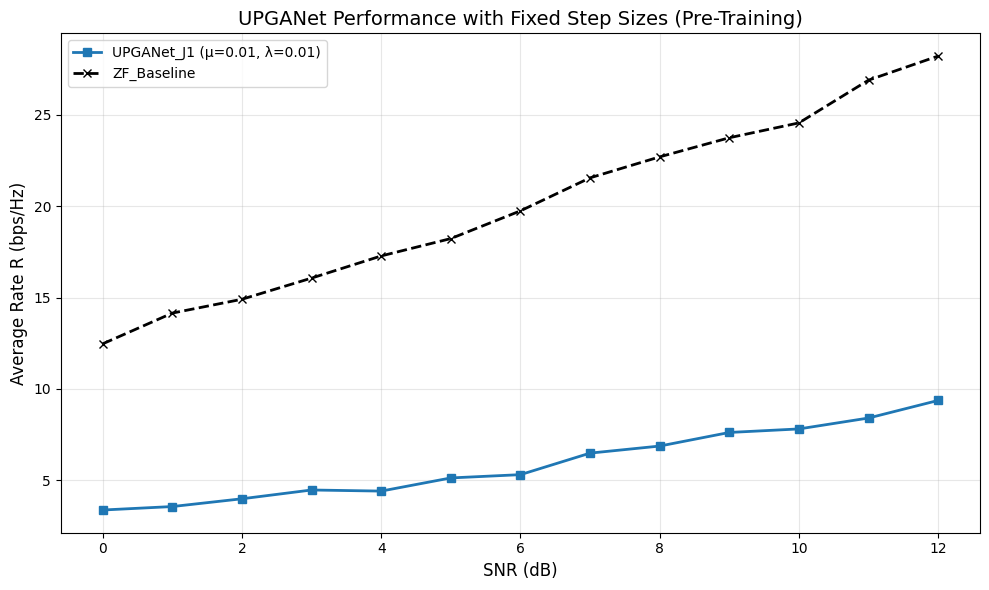


NUMERICAL RESULTS
SNR (dB)    UPGANet_J1_fixed         ZF_Baseline              
----------------------------------------------------------------------
0           3.3661                   12.4656                  
1           3.5563                   14.1483                  
2           3.9817                   14.9061                  
3           4.4628                   16.0652                  
4           4.4024                   17.2779                  
5           5.1233                   18.2288                  
6           5.3029                   19.7473                  
7           6.4820                   21.5553                  
8           6.8687                   22.7031                  
9           7.6129                   23.7494                  
10          7.8065                   24.5629                  
11          8.4039                   26.9059                  
12          9.3669                   28.2234                  

PRE-TRAINING EVALUATION COM

In [138]:
# Pre-Training Evaluation: UPGANet with Fixed Step Sizes (μ = 0.01, λ = 0.01)
# This allows comparison with the earlier PGA results before learning step sizes

def evaluate_fixed_step_upganet(J_values=[1], num_realizations=40, snr_range=range(0, 13)):
    """
    Evaluate UPGANet with fixed step sizes (no training)
    This should match the earlier PGA results
    """
    print("="*70)
    print("EVALUATING UPGANet WITH FIXED STEP SIZES (μ=0.004, λ=0.016)")
    print("="*70)
    print(f"Device: {device}")
    print(f"Number of realizations per SNR: {num_realizations}")
    print(f"SNR range: {list(snr_range)} dB")
    print()
    
    results = {}
    
    for J in J_values:
        print(f"\n{'='*60}")
        print(f"Evaluating with J = {J}")
        print(f"{'='*60}")
        
        # Create model with fixed step sizes
        model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
        
        # Set all step sizes to 0.01 (no training)
        with torch.no_grad():
            for layer in model.layers:
                layer.mu.fill_(0.004)  # Set all mu values to 0.01
                layer.lambda_.fill_(0.016)  # Set lambda to 0.01
        
        model.eval()  # Set to evaluation mode
        
        R_PGA_list = []
        
        for snr_db in snr_range:
            R_PGA_sum = 0.0
            P_BS = sigma_n2 * 10**(snr_db / 10)
            
            for realization in range(num_realizations):
                # Generate channel on GPU
                H_t = generate_channel_torch(N, M, L=20, device=device)
                
                # Get Psi
                Psi_np = compute_psi(snr_db)
                Psi_t = torch.tensor(Psi_np, dtype=torch.cfloat, device=device)
                
                # Power
                P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
                
                # Initialize
                A0, D0 = proposed_initialization_torch(H_t, theta_d_t, N, M, K, P_BS, device=device)
                
                # Forward pass through UPGANet (no gradient computation)
                with torch.no_grad():
                    A_final, D_final = model(H_t, A0, D0, Psi_t, sigma_n2_t, P_BS_t)
                
                # Compute rate
                R = compute_rate_torch(H_t, A_final, D_final, sigma_n2_t)
                R_PGA_sum += R.item()
            
            R_PGA_avg = R_PGA_sum / num_realizations
            R_PGA_list.append(R_PGA_avg)
            print(f"SNR = {snr_db:2d} dB → Avg R = {R_PGA_avg:.4f} bps/Hz")
        
        results[f'UPGANet_J{J}_fixed'] = R_PGA_list
    
    # Also compute ZF baseline
    print(f"\n{'='*60}")
    print("Computing ZF Baseline")
    print(f"{'='*60}")
    
    R_ZF_list = []
    for snr_db in snr_range:
        R_ZF_sum = 0.0
        P_BS = sigma_n2 * 10**(snr_db / 10)
        
        for realization in range(num_realizations):
            H_t = generate_channel_torch(N, M, L=20, device=device)
            if H_t.shape[0] != K:
                H_t = H_t.T
            P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
            R_ZF = compute_R_ZF_torch(H_t, sigma_n2_t, P_BS_t, device=device)
            R_ZF_sum += R_ZF.item()
        
        R_ZF_avg = R_ZF_sum / num_realizations
        R_ZF_list.append(R_ZF_avg)
        print(f"SNR = {snr_db:2d} dB → ZF Avg R = {R_ZF_avg:.4f} bps/Hz")
    
    results['ZF_Baseline'] = R_ZF_list
    
    return results

def plot_fixed_step_results(results, snr_range=range(0, 13)):
    """
    Plot the results from fixed step size evaluation
    """
    plt.figure(figsize=(10, 6))
    
    snrs = list(snr_range)
    
    # Plot each configuration
    for label, rates in results.items():
        if 'ZF' in label:
            plt.plot(snrs, rates, marker='x', linewidth=2, 
                    color='black', linestyle='--', label=label)
        elif 'J1' in label:
            plt.plot(snrs, rates, marker='s', linewidth=2, 
                    label=label.replace('_fixed', ' (μ=0.01, λ=0.01)'))
        elif 'J10' in label:
            plt.plot(snrs, rates, marker='o', linewidth=2, 
                    label=label.replace('_fixed', ' (μ=0.01, λ=0.01)'))
        else:
            plt.plot(snrs, rates, marker='d', linewidth=2, label=label)
    
    plt.xlabel('SNR (dB)', fontsize=12)
    plt.ylabel('Average Rate R (bps/Hz)', fontsize=12)
    plt.title('UPGANet Performance with Fixed Step Sizes (Pre-Training)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print numerical results
    print("\n" + "="*70)
    print("NUMERICAL RESULTS")
    print("="*70)
    print(f"{'SNR (dB)':<12}", end='')
    for label in results.keys():
        print(f"{label:<25}", end='')
    print()
    print("-"*70)
    
    for i, snr in enumerate(snrs):
        print(f"{snr:<12}", end='')
        for label in results.keys():
            print(f"{results[label][i]:<25.4f}", end='')
        print()

# Run the evaluation
print("Running pre-training evaluation with fixed step sizes...")
print("This will take a few minutes...\n")

fixed_results = evaluate_fixed_step_upganet(J_values=[1], num_realizations=40, snr_range=range(0, 13))

# Plot results
plot_fixed_step_results(fixed_results, snr_range=range(0, 13))

print("\n" + "="*70)
print("PRE-TRAINING EVALUATION COMPLETE")
print("="*70)
print("\nThese results should closely match your earlier PGA implementation.")
print("After training, you can compare learned vs fixed step sizes!")


===== Initialization: Proposed =====
  → Running for J = 10


/tmp/ipykernel_1380899/2247011883.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R_omega_tau.append(float(np.real(R - omega * tau)))


    ✓ Averaged over 100 realizations
  → Running for J = 20
    ✓ Averaged over 100 realizations

===== Initialization: Random =====
  → Running for J = 10
    ✓ Averaged over 100 realizations
  → Running for J = 20
    ✓ Averaged over 100 realizations

===== Initialization: SVD =====
  → Running for J = 10
    ✓ Averaged over 100 realizations
  → Running for J = 20
    ✓ Averaged over 100 realizations


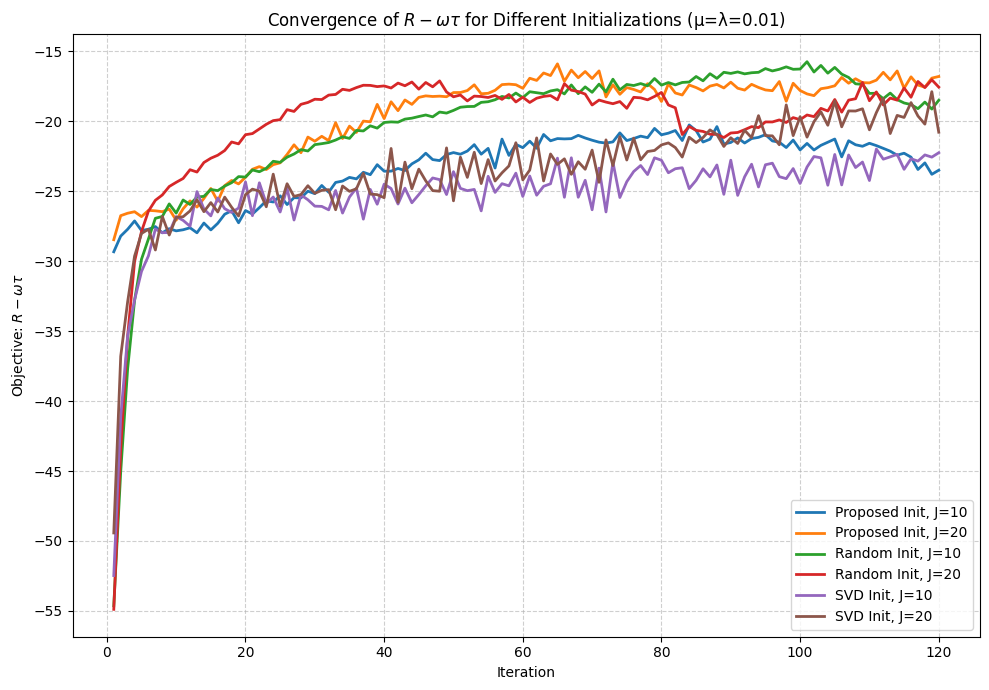

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# === Initialization Methods ===
def proposed_initialization(H, theta_d, N, M, K, P_BS):
    G = np.array([H[k, :] for k in range(K)]).T  # N x K
    A0 = np.exp(-1j * np.angle(G))[:, :M]
    X_ZF = np.linalg.pinv(H)
    D0 = np.linalg.pinv(A0) @ X_ZF
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def random_initialization(N, M, H, P_BS):
    A0 = np.exp(1j * np.random.uniform(0, 2 * np.pi, (N, M)))
    H_A = H @ A0
    D0 = np.linalg.pinv(H_A)
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

def svd_initialization(H, N, M, K, P_BS):
    _, _, Vh = np.linalg.svd(H, full_matrices=False)
    A0 = Vh.T[:, :M]
    A0 = np.exp(1j * np.angle(A0))  # enforce unit modulus
    H_A = H @ A0
    try:
        D0 = np.linalg.pinv(H_A)
    except np.linalg.LinAlgError:
        D0 = np.linalg.pinv(H_A + 1e-6 * np.eye(M))
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')
    return A0, D0

# === PGA Algorithm ===
def run_pga(H, A0, D0, J, I_max, mu, lambda_, omega, sigma_n2, Psi, theta_grid, P_BS):
    A = A0.copy()
    D = D0.copy()
    eta = 1 / N
    R_omega_tau = []

    for i in range(I_max):
        # --- Analog precoder update ---
        A_hat = A.copy()
        for j in range(J):
            grad_R_A = gradient_R_A(H, A_hat, D, sigma_n2)
            grad_tau_A = gradient_tau_A(A_hat, D, Psi)
            grad_A = grad_R_A - omega * grad_tau_A
            A_hat = A_hat + mu * grad_A
            A_hat = np.exp(1j * np.angle(A_hat))  # unit modulus projection

        A = A_hat.copy()

        # --- Digital precoder update ---
        grad_R_D = gradient_R_D(H, A, D, sigma_n2)
        grad_tau_D = gradient_tau_D(A, D, Psi)
        grad_D = grad_R_D - omega * eta * grad_tau_D
        D = D + lambda_ * grad_D
        D = np.sqrt(P_BS) * D / np.linalg.norm(A @ D, 'fro')  # power normalization

        # --- Objective: R - ωτ ---
        R = compute_rate(H, A, D, sigma_n2)
        tau = compute_tau(A, D, Psi, theta_grid)
        R_omega_tau.append(float(np.real(R - omega * tau)))

    return np.array(R_omega_tau)

# === Experiment Parameters ===
I_max = 120
mu = 0.01
lambda_ = 0.01
omega = 0.3
J_list = [10,20]
num_realizations = 100

snr_db = 12
P_BS = sigma_n2 * 10**(snr_db / 10)
Psi = compute_psi(snr_db)

# === Initialization methods to test ===
init_methods = {
    "Proposed": proposed_initialization,
    "Random": random_initialization,
    "SVD": svd_initialization
}

# === Storage for results ===
R_omega_tau_results = {init: {J: np.zeros(I_max) for J in J_list} for init in init_methods}

# === Main Experiment ===
for init_name, init_func in init_methods.items():
    print(f"\n===== Initialization: {init_name} =====")
    for J in J_list:
        print(f"  → Running for J = {J}")
        for realization in range(num_realizations):
            H = generate_channel(N, M, L)
            if init_name == "Proposed":
                A0, D0 = init_func(H, theta_d, N, M, K, P_BS)
            elif init_name == "Random":
                A0, D0 = init_func(N, M, H, P_BS)
            elif init_name == "SVD":
                A0, D0 = init_func(H, N, M, K, P_BS)
            else:
                raise ValueError("Unknown initialization type.")

            R_omega_tau = run_pga(H, A0, D0, J=J, I_max=I_max,
                                  mu=mu, lambda_=lambda_, omega=omega,
                                  sigma_n2=sigma_n2, Psi=Psi,
                                  theta_grid=theta_grid, P_BS=P_BS)
            R_omega_tau_results[init_name][J] += R_omega_tau

        # Average across all realizations
        R_omega_tau_results[init_name][J] /= num_realizations
        print(f"    ✓ Averaged over {num_realizations} realizations")

# === Plot Results ===
plt.figure(figsize=(10, 7))
for init_name in init_methods.keys():
    for J in J_list:
        plt.plot(range(1, I_max + 1),
                 R_omega_tau_results[init_name][J],
                 linewidth=2,
                 label=f'{init_name} Init, J={J}')

plt.xlabel('Iteration')
plt.ylabel(r'Objective: $R - \omega \tau$')
plt.title(r'Convergence of $R - \omega \tau$ for Different Initializations (μ=λ=0.01)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [142]:

def evaluate_upganet_convergence(model, H_t, Psi_t, sigma_n2_t, P_BS_t,
                                 A0, D0, omega, theta_grid_t):
    """
    Runs the UPGANet forward pass layer-by-layer and tracks R - ωτ per iteration.
    """
    model.eval()
    A, D = A0.clone(), D0.clone()
    R_omega_tau_list = []

    with torch.no_grad():
        for layer in model.layers:
            # Each layer performs the analog + digital precoder updates
            A, D = layer(H_t, A, D, Psi_t, sigma_n2_t, P_BS_t)

            # Compute metrics per iteration
            R = compute_rate_torch(H_t, A, D, sigma_n2_t)
            tau = compute_tau_torch(A, D, Psi_t)
            R_omega_tau = R - omega * tau
            R_omega_tau_list.append(R_omega_tau.item())

    return np.array(R_omega_tau_list)



def run_convergence_experiment_upganet(J=10, num_realizations=50, 
                                       mu_fixed=0.01, lambda_fixed=0.01):
    """
    Compare R - ωτ convergence (per iteration) for different initialization types
    using fixed-step UPGANet.
    """
    print("="*70)
    print(f"UPGANet Convergence (R - ωτ) vs Iteration | J={J}, μ={mu_fixed}, λ={lambda_fixed}")
    print("="*70)
    
    # Create model (fixed step sizes)
    model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    with torch.no_grad():
        for layer in model.layers:
            layer.mu.fill_(mu_fixed)
            layer.lambda_.fill_(lambda_fixed)

    init_methods = {
        "Proposed": proposed_initialization_torch,
        "Random": random_initialization_torch,
        "SVD": svd_initialization_torch
    }

    convergence_results = {name: np.zeros(I_max) for name in init_methods}

    # === Run over multiple realizations ===
    for realization in range(num_realizations):
        H_t = generate_channel_torch(N, M, L=20, device=device)
        Psi_np = compute_psi(12)  # example: fixed SNR = 12 dB
        Psi_t = torch.tensor(Psi_np, dtype=torch.cfloat, device=device)
        P_BS_t = torch.tensor(sigma_n2 * 10**(12 / 10), dtype=torch.float32, device=device)

        for init_name, init_func in init_methods.items():
            # Initialize A0, D0
            if init_name == "Proposed":
                A0, D0 = init_func(H_t, theta_d_t, N, M, K, P_BS_t, device=device)
            elif init_name == "Random":
                A0, D0 = init_func(N, M, H_t, P_BS_t, device=device)
            elif init_name == "SVD":
                A0, D0 = init_func(H_t, N, M, K, P_BS_t, device=device)
            
            # Evaluate convergence curve
            R_omega_tau_curve = evaluate_upganet_convergence(
                model, H_t, Psi_t, sigma_n2_t, P_BS_t, A0, D0, omega, theta_grid_t
            )

            # Accumulate
            convergence_results[init_name][:len(R_omega_tau_curve)] += R_omega_tau_curve

    # Average across realizations
    for init_name in init_methods:
        convergence_results[init_name] /= num_realizations

    # === Plot ===
    plt.figure(figsize=(9, 6))
    for init_name, curve in convergence_results.items():
        plt.plot(range(1, len(curve) + 1), curve, linewidth=2, label=f"{init_name} Init")

    plt.xlabel('Iteration')
    plt.ylabel(r'$R - \omega\tau$ (bps/Hz)')
    plt.title(f'UPGANet Convergence for Different Initializations (μ={mu_fixed}, λ={lambda_fixed})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return convergence_results


UPGANet Convergence (R - ωτ) vs Iteration | J=1, μ=0.01, λ=0.01


/tmp/ipykernel_1380899/803797241.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
/tmp/ipykernel_1380899/803797241.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
/tmp/ipykernel_1380899/803797241.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')

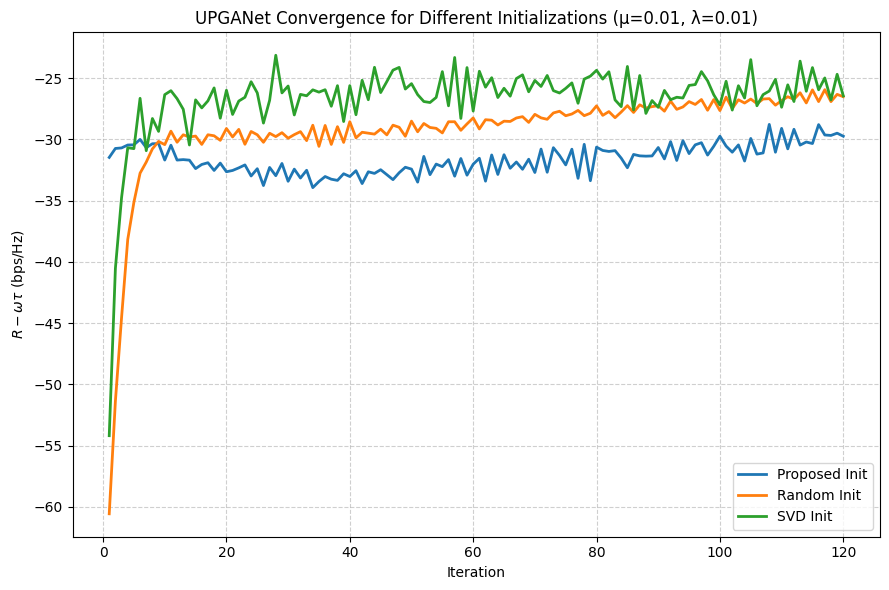

In [151]:
convergence_results = run_convergence_experiment_upganet(
    J=1,
    num_realizations=50,
    mu_fixed=0.01,
    lambda_fixed=0.01
)


In [149]:
# Example: load your trained UPGANet model
model = UPGANet(N, M, K, omega, I_max=40, J=1).to(device)
model.load_state_dict(torch.load("checkpoints/upganet_J1_final.pth", map_location=device))
model.eval()



def evaluate_upganet_convergence_trained(model, H_t, Psi_t, sigma_n2_t, P_BS_t,
                                         A0, D0, omega, theta_grid_t):
    """
    Evaluate trained UPGANet: return R - ωτ per iteration.
    """
    model.eval()
    A, D = A0.clone(), D0.clone()
    R_omega_tau_list = []

    with torch.no_grad():
        for layer in model.layers:
            # Each layer corresponds to one unrolled PGA iteration
            A, D = layer(H_t, A, D, Psi_t, sigma_n2_t, P_BS_t)

            R = compute_rate_torch(H_t, A, D, sigma_n2_t)
            tau = compute_tau_torch(A, D, Psi_t)
            R_omega_tau_list.append((R - omega * tau).item())

    return np.array(R_omega_tau_list)


def run_convergence_experiment_upganet_trained(model, num_realizations=100, snr_db=12):
    """
    Evaluate trained UPGANet convergence (R - ωτ vs iteration)
    for multiple initialization strategies.
    """
    print("="*70)
    print(f"Evaluating trained UPGANet: R - ωτ vs Iteration | SNR={snr_db} dB")
    print("="*70)

    init_methods = {
        "Proposed": proposed_initialization_torch,
        "Random": random_initialization_torch,
        "SVD": svd_initialization_torch
    }

    convergence_results = {name: np.zeros(model.I_max) for name in init_methods}

    # Fixed SNR setup
    Psi_np = compute_psi(snr_db)
    Psi_t = torch.tensor(Psi_np, dtype=torch.cfloat, device=device)
    P_BS_t = torch.tensor(sigma_n2 * 10**(snr_db / 10), dtype=torch.float32, device=device)

    # === Loop over realizations ===
    for realization in range(num_realizations):
        H_t = generate_channel_torch(N, M, L=20, device=device)

        for init_name, init_func in init_methods.items():
            if init_name == "Proposed":
                A0, D0 = init_func(H_t, theta_d_t, N, M, K, P_BS_t, device=device)
            elif init_name == "Random":
                A0, D0 = init_func(N, M, H_t, P_BS_t, device=device)
            elif init_name == "SVD":
                A0, D0 = init_func(H_t, N, M, K, P_BS_t, device=device)

            # Evaluate convergence curve
            R_omega_tau_curve = evaluate_upganet_convergence_trained(
                model, H_t, Psi_t, sigma_n2_t, P_BS_t, A0, D0, omega, theta_grid_t
            )
            convergence_results[init_name][:len(R_omega_tau_curve)] += R_omega_tau_curve

    # Average across all realizations
    for init_name in convergence_results:
        convergence_results[init_name] /= num_realizations

    # === Plot Results ===
    plt.figure(figsize=(9, 6))
    for init_name, curve in convergence_results.items():
        plt.plot(range(1, len(curve) + 1), curve, linewidth=2, label=f"{init_name} Init")

    plt.xlabel("Iteration")
    plt.ylabel(r"$R - \omega\tau$ (bps/Hz)")
    plt.title("Trained UPGANet Convergence for Different Initializations")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return convergence_results


Evaluating trained UPGANet: R - ωτ vs Iteration | SNR=12 dB


/tmp/ipykernel_1380899/803797241.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
/tmp/ipykernel_1380899/803797241.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')
/tmp/ipykernel_1380899/803797241.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D0 = torch.sqrt(torch.tensor(P_BS, device=device)) * D0 / torch.linalg.norm(A0 @ D0, ord='fro')

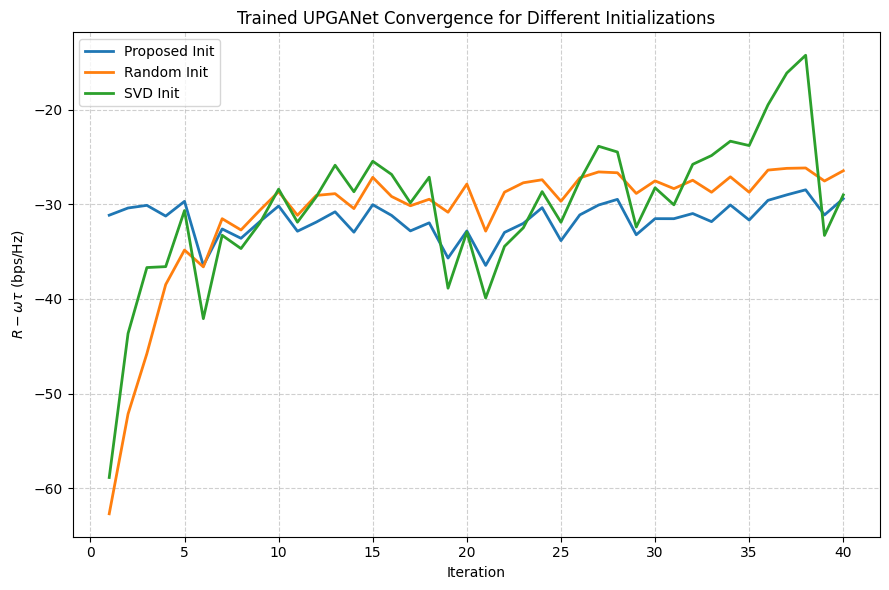

In [150]:
trained_convergence_results = run_convergence_experiment_upganet_trained(
    model,
    num_realizations=100,
    snr_db=12  # or any desired test SNR
)


In [153]:
def evaluate_trained_upganet(model_path, J=1, num_realizations=40, snr_range=range(0, 13)):
    """
    Evaluate a trained UPGANet model and compute the average achievable rate vs SNR.
    """
    print("="*70)
    print(f"EVALUATING TRAINED UPGANet (J={J})")
    print("="*70)
    print(f"Model path: {model_path}")
    print(f"Device: {device}")
    print()

    # Instantiate model with the same I_max as training
    trained_model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    state_dict = torch.load(model_path, map_location=device)
    trained_model.load_state_dict(state_dict, strict=False)
    trained_model.eval()

    R_upganet_list = []

    for snr_db in snr_range:
        R_sum = 0.0
        P_BS = sigma_n2 * 10**(snr_db / 10)

        for realization in range(num_realizations):
            H_t = generate_channel_torch(N, M, L=20, device=device)
            Psi_t = torch.tensor(compute_psi(snr_db), dtype=torch.cfloat, device=device)
            P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)

            # Initialization (same as before)
            A0, D0 = proposed_initialization_torch(H_t, theta_d_t, N, M, K, P_BS, device=device)

            with torch.no_grad():
                A_final, D_final = trained_model(H_t, A0, D0, Psi_t, sigma_n2_t, P_BS_t)

            # Compute achievable rate
            R = compute_rate_torch(H_t, A_final, D_final, sigma_n2_t)
            R_sum += R.item()

        R_avg = R_sum / num_realizations
        R_upganet_list.append(R_avg)
        print(f"SNR = {snr_db:2d} dB → Avg R = {R_avg:.4f} bps/Hz")

    return R_upganet_list


EVALUATING TRAINED UPGANet (J=1)
Model path: checkpoints/upganet_J1_final.pth
Device: cpu

SNR =  0 dB → Avg R = 3.6033 bps/Hz
SNR =  1 dB → Avg R = 4.0710 bps/Hz
SNR =  2 dB → Avg R = 4.5684 bps/Hz
SNR =  3 dB → Avg R = 4.9025 bps/Hz
SNR =  4 dB → Avg R = 5.7442 bps/Hz
SNR =  5 dB → Avg R = 6.2776 bps/Hz
SNR =  6 dB → Avg R = 6.5732 bps/Hz
SNR =  7 dB → Avg R = 7.8217 bps/Hz
SNR =  8 dB → Avg R = 8.2882 bps/Hz
SNR =  9 dB → Avg R = 9.0408 bps/Hz
SNR = 10 dB → Avg R = 9.9293 bps/Hz
SNR = 11 dB → Avg R = 10.7728 bps/Hz
SNR = 12 dB → Avg R = 12.3989 bps/Hz


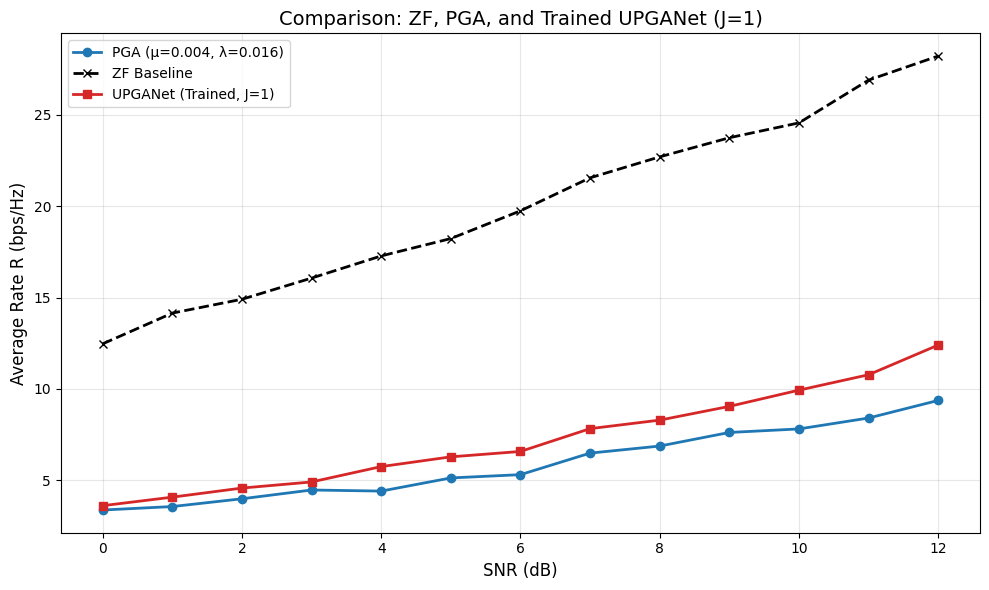

In [154]:
# Evaluate trained UPGANet (J=1)
trained_results = evaluate_trained_upganet(
    model_path="checkpoints/upganet_J1_final.pth",
    J=1,
    num_realizations=40,
    snr_range=range(0, 13)
)

# Add to results dictionary
fixed_results['UPGANet_J1_trained'] = trained_results

# Re-plot including trained model
plt.figure(figsize=(10, 6))
snrs = list(range(0, 13))

for label, rates in fixed_results.items():
    if 'ZF' in label:
        plt.plot(snrs, rates, marker='x', linewidth=2, color='black', linestyle='--', label='ZF Baseline')
    elif 'fixed' in label:
        plt.plot(snrs, rates, marker='o', linewidth=2, color='tab:blue', label='PGA (μ=0.004, λ=0.016)')
    elif 'trained' in label:
        plt.plot(snrs, rates, marker='s', linewidth=2, color='tab:red', label='UPGANet (Trained, J=1)')

plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('Average Rate R (bps/Hz)', fontsize=12)
plt.title('Comparison: ZF, PGA, and Trained UPGANet (J=1)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
